# Pancreas Dataset
- [Tutorial Notebook](https://colab.research.google.com/github/iml-dkfz/nnunet-workshop/blob/master/nnU-Net_Workshop.ipynb#scrollTo=iBxlyQ3rY7X_)
- [Datasets Drive](https://drive.google.com/drive/folders/1HqEgzS8BV2c7xYNrZdEAnrHk7osJJ--2)
- [M3D-CAM w/ nnUNet](https://colab.research.google.com/drive/1b6LMbSM3dvpCS4jEsWVpmgTbsR_rVPUF?usp=sharing)

In [1]:
import os
import shutil
from collections import OrderedDict

import json
import matplotlib.pyplot as plt
import nibabel as nib

import numpy as np
import torch

In [2]:
# check whether GPU accelerated computing is available
assert torch.cuda.is_available() # if there is an error here, enable GPU in the Runtime

In [157]:
import nnunetv2

# Data Preparation

In [6]:
import os
import shutil
import json
import nibabel as nib
import numpy as np

# Define the source directories
source_train = 'original_data/UHN-MedImg3D-ML-quiz/train'
source_val = 'original_data/UHN-MedImg3D-ML-quiz/validation'
source_test = 'original_data/UHN-MedImg3D-ML-quiz/test'

# Define the target directories
target_base = 'original_data'
task_name = 'Task06_PancreasUHN'
target_task_dir = os.path.join(target_base, task_name)
images_tr_dir = os.path.join(target_task_dir, 'imagesTr')
images_ts_dir = os.path.join(target_task_dir, 'imagesTs')
labels_tr_dir = os.path.join(target_task_dir, 'labelsTr')

# Create the target directories if they don't exist
os.makedirs(images_tr_dir, exist_ok=True)
os.makedirs(images_ts_dir, exist_ok=True)
os.makedirs(labels_tr_dir, exist_ok=True)

# Initialize class mapping dictionary
class_mapping = {}

# Function to correct label values
def correct_labels(file_path):
    img = nib.load(file_path)
    data = img.get_fdata()

    print(f"Original unique labels in {file_path}: {np.unique(data)}")

    # Round to nearest valid value
    data_corrected = np.round(data)

    # Explicitly set near values to the exact intended labels
    data_corrected[np.isclose(data_corrected, 0.0)] = 0.0
    data_corrected[np.isclose(data_corrected, 1.0)] = 1.0
    data_corrected[np.isclose(data_corrected, 2.0)] = 2.0

    print(f"Corrected unique labels in {file_path}: {np.unique(data_corrected)}")
    print(f"----------------------------------------------------------------------\n\n")

    # Save the corrected label file to a temporary path
    temp_file_path = file_path.replace('.nii.gz', '_corrected.nii.gz')
    # corrected_img = nib.Nifti1Image(data_corrected, img.affine, img.header)
    corrected_img = nib.Nifti1Image(data_corrected, img.affine)
    
    nib.save(corrected_img, temp_file_path)
    
    return temp_file_path, np.unique(data_corrected), np.unique(data)

# Function to move files and record class labels
def move_files(source, image_dest, label_dest, class_mapping, case_id=0):
    
    if not label_dest:
        case_id = case_id
        total = len(os.listdir(source))
        for file in os.listdir(source):
            if file.endswith('0000.nii.gz'):
                src_image_file = os.path.join(source, file)

                case_str_image = f"case_{case_id:04d}_0000.nii.gz"
                dest_image_file = os.path.join(image_dest, case_str_image)
                shutil.copy(src_image_file, dest_image_file)
                
                print(f"""({case_id}/{total}) Source Image: {src_image_file} 
                      Dest Image: {dest_image_file}
                      Labels: No Class, Not Annotated
                """)
                case_id += 1
                
        return case_id
            
    else:
        case_id = case_id
        for subtype in os.listdir(source):
            subtype_path = os.path.join(source, subtype)
            if os.path.isdir(subtype_path):
                class_id = int(os.path.basename(subtype_path)[-1])
                total = len(os.listdir(subtype_path))
                for file in os.listdir(subtype_path):
                    if file.endswith('0000.nii.gz'):
                        src_image_file = os.path.join(subtype_path, file)

                        case_str_image = f"case_{case_id:04d}_0000.nii.gz"
                        dest_image_file = os.path.join(image_dest, case_str_image)
                        shutil.copy(src_image_file, dest_image_file)

                        src_label_file = src_image_file.replace('_0000.nii.gz', '.nii.gz')
                        
                        # Correct the label file before copying
                        corrected_label_file, unique_labels, orig_labels = correct_labels(src_label_file)
                        # print(corrected_label_file)
                        # print(unique_labels)
                        # print(orig_labels)

                        case_str_label = f"case_{case_id:04d}.nii.gz"
                        dest_label_file = os.path.join(label_dest, case_str_label)
                        
                        shutil.copy(corrected_label_file, dest_label_file)
                        
                        class_mapping[case_str_image] = class_id
                        print(f"""
                        
----------------------------------------------------------------------
({case_id}/{total}) 

Source Image: {src_image_file}
Source Label: {src_label_file}
Corrected Label: {corrected_label_file}
Dest Image: {dest_image_file}
Dest Label: {dest_label_file}
Labels: Class {class_id}, Annotated, Unique labels after correction: {unique_labels}
                        
                        """)
                        case_id += 1
                        # Remove the temporary corrected label file
                        os.remove(corrected_label_file)
                        
        return case_id

# Move training files and record class labels
case_id = move_files(source_train, images_tr_dir, labels_tr_dir, class_mapping, 0)
print("\n\n##################\n\n")
case_id = move_files(source_val, images_tr_dir, labels_tr_dir, class_mapping, case_id)
print("\n\n##################\n\n")
move_files(source_test, images_ts_dir, None, class_mapping)

# Save the class mapping to a JSON file
with open(os.path.join(target_task_dir, 'class_mapping.json'), 'w') as f:
    json.dump(class_mapping, f)

print("Data restructuring complete and class mapping saved.")


Original unique labels in original_data/UHN-MedImg3D-ML-quiz/train/subtype2/quiz_2_416.nii.gz: [0. 1. 2.]
Corrected unique labels in original_data/UHN-MedImg3D-ML-quiz/train/subtype2/quiz_2_416.nii.gz: [0. 1. 2.]
----------------------------------------------------------------------



                        
----------------------------------------------------------------------
(0/170) 

Source Image: original_data/UHN-MedImg3D-ML-quiz/train/subtype2/quiz_2_416_0000.nii.gz
Source Label: original_data/UHN-MedImg3D-ML-quiz/train/subtype2/quiz_2_416.nii.gz
Corrected Label: original_data/UHN-MedImg3D-ML-quiz/train/subtype2/quiz_2_416_corrected.nii.gz
Dest Image: original_data/Task06_PancreasUHN/imagesTr/case_0000_0000.nii.gz
Dest Label: original_data/Task06_PancreasUHN/labelsTr/case_0000.nii.gz
Labels: Class 2, Annotated, Unique labels after correction: [0. 1. 2.]
                        
                        
Original unique labels in original_data/UHN-MedImg3D-ML-quiz/train/subtype2

# Verify Labels

In [7]:
import os
import numpy as np
import nibabel as nib

def load_nifti_image(file_path):
    """Load a NIfTI image and return the data as a numpy array."""
    nifti_image = nib.load(file_path)
    return nifti_image.get_fdata()

def collect_unique_labels(labels_dir):
    """Collect and print all unique labels in the dataset."""
    unique_labels = set()
    
    label_files = sorted(os.listdir(labels_dir))
    
    for lbl_file in label_files:
        lbl_path = os.path.join(labels_dir, lbl_file)
        labels = load_nifti_image(lbl_path)
        unique_labels.update(np.unique(labels))
    
    return unique_labels

In [8]:
# Define the path to the labels directory
t6_labels_dir = 'original_data/Task06_PancreasUHN/labelsTr'

# Collect unique labels
t6_unique_labels = collect_unique_labels(t6_labels_dir)

# Print the unique labels
print(f"Unique labels in the dataset: {sorted(t6_unique_labels)}")


Unique labels in the dataset: [0.0, 1.0, 2.0]


In [15]:
! pwd
! ls original_data/Task06_PancreasUHN/imagesTr | wc -l
! ls original_data/Task06_PancreasUHN/labelsTr | wc -l
! ls original_data/Task06_PancreasUHN/imagesTs | wc -l

/scratch/alif/nnUNet
288
288
72


In [14]:
# os.environ['RAW_DATA_PATH']

# Dataset Building

In [18]:
import os
import json

def create_dataset_json(base_dir, task_name, num_training, num_test):
    
    imagesTr_dir = os.path.join(base_dir, task_name, 'imagesTr')
    labelsTr_dir = os.path.join(base_dir, task_name, 'labelsTr')
    imagesTs_dir = os.path.join(base_dir, task_name, 'imagesTs')

    # Get list of training and test images
    training_images = sorted(os.listdir(imagesTr_dir))
    test_images = sorted(os.listdir(imagesTs_dir))

    # Ensure the number of requested training and test images does not exceed available images
    num_training = min(num_training, len(training_images))
    num_test = min(num_test, len(test_images))

    # Create the dataset dictionary
    dataset = {
        "name": "Pancreas_UHN",
        "description": "Segmentation of pancreatic structures using UHN dataset",
        "tensorImageSize": "3D",
        "reference": "",
        "licence": "",
        "release": "0.0",
        "modality": {
            "0": "CT"
        },
        "labels": {
            "0": "background",
            "1": "pancreas",
            "2": "lesion"
            # Add other structures as needed
        },
        "numTraining": num_training,
        "numTest": num_test,
        "training": [],
        "test": []
    }

    # Populate the training field
    for i in range(num_training):
        dataset['training'].append({
            "image": f"{imagesTr_dir}/{training_images[i]}",
            "label": f"{labelsTr_dir}/{training_images[i].replace('_0000.nii.gz', '.nii.gz')}"
        })

    # Populate the test field
    for i in range(num_test):
        dataset['test'].append(f"{imagesTs_dir}/{test_images[i]}")

    # Save the dataset.json file
    with open(os.path.join(base_dir, task_name, 'dataset.json'), 'w') as f:
        json.dump(dataset, f, indent=4)

# Define the parameters
base_dir = os.environ['RAW_DATA_PATH']
task_name = 'Task06_PancreasUHN'  # Replace 002 with the actual task number
num_training = 288  # Set the number of training samples
num_test = 72  # Set the number of test samples

# Create the dataset.json file
create_dataset_json(base_dir, task_name, num_training, num_test)
print('Done')

Done


# Convert & Pre-Process

In [46]:
def make_if_dont_exist(folder_path,overwrite=False):
    """
    creates a folder if it does not exists
    input: 
    folder_path : relative path of the folder which needs to be created
    over_write :(default: False) if True overwrite the existing folder 
    """
    if os.path.exists(folder_path):
        
        if not overwrite:
            print(f"{folder_path} exists.")
        else:
            print(f"{folder_path} overwritten")
            shutil.rmtree(folder_path)
            os.makedirs(folder_path)

    else:
      os.makedirs(folder_path)
      print(f"{folder_path} created!")

# Maybe move path of preprocessed data directly on content - this may be signifcantely faster!
print("Current Working Directory {}".format(os.getcwd()))
path_dict = {
    "nnUNet_raw" : os.path.join(os.getcwd(), "nnUNet_raw"), 
    "nnUNet_preprocessed" : os.path.join(os.getcwd(), "nnUNet_preprocessed"), # 1 experiment: 1 epoch took 112s
    "nnUNet_results" : os.path.join(os.getcwd(), "nnUNet_results"),
    "RAW_DATA_PATH" : os.path.join(os.getcwd(), "original_data"), # This is used here only for convenience (not necessary for nnU-Net)!
}

# Write paths to environment variables
for env_var, path in path_dict.items():
  os.environ[env_var] = path 

# Check whether all environment variables are set correct!
for env_var, path in path_dict.items():
  if os.getenv(env_var) != path:
    print("Error:")
    print("Environment Variable {} is not set correctly!".format(env_var))
    print("Should be {}".format(path))
    print("Variable is {}".format(os.getenv(env_var)))
  make_if_dont_exist(path, overwrite=False)

print("If No Error Occured Continue Forward. =)")

Current Working Directory /scratch/alif/nnUNet
/scratch/alif/nnUNet/nnUNet_raw exists.
/scratch/alif/nnUNet/nnUNet_preprocessed exists.
/scratch/alif/nnUNet/nnUNet_results exists.
/scratch/alif/nnUNet/original_data exists.
If No Error Occured Continue Forward. =)


In [47]:
# os.environ['nnUNet_raw_data_base'] = '/scratch/alif/nnUNet/original_data'
os.environ['nnUNet_raw_data_base'] = '/scratch/alif/nnUNet/nnUNet_raw_data_base'
os.environ['nnUNet_preprocessed'] = '/scratch/alif/nnUNet/nnUNet_preprocessed'
os.environ['RESULTS_FOLDER'] = '/scratch/alif/nnUNet/nnUNet_trained_models'

In [73]:
! nnUNet_plan_and_preprocess -t 006 --verify_dataset_integrity



Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet

Traceback (most recent call last):
  File "/home/alif/.local/bin/nnUNet_plan_and_preprocess", line 33, in <module>
    sys.exit(load_entry_point('nnunet', 'console_scripts', 'nnUNet_plan_and_preprocess')())
  File "/scratch/alif/nnUNet/nnunet/experiment_planning/nnUNet_plan_and_preprocess.py", line 105, in main
    verify_dataset_integrity(join(nnUNet_raw_data, task_name))
  File "/scratch/alif/nnUNet/nnunet/preprocessing/sanity_checks.py", line 105, in verify_dataset_integrity
    training_cases = dataset['training']
KeyError: 'training'


In [74]:
! nnUNet_plan_and_preprocess -t 006



Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet

Traceback (most recent call last):
  File "/home/alif/.local/bin/nnUNet_plan_and_preprocess", line 33, in <module>
    sys.exit(load_entry_point('nnunet', 'console_scripts', 'nnUNet_plan_and_preprocess')())
  File "/scratch/alif/nnUNet/nnunet/experiment_planning/nnUNet_plan_and_preprocess.py", line 107, in main
    crop(task_name, False, tf)
  File "/scratch/alif/nnUNet/nnunet/experiment_planning/utils.py", line 131, in crop
    lists, _ = create_lists_from_splitted_dataset(splitted_4d_output_dir_task)
  File "/scratch/alif/nnUNet/nnunet/experiment_planning/utils.py", line 88, in create_lists_from_splitted_dataset
    training_fil

In [48]:
! nnUNetv2_convert_MSD_dataset -i "${RAW_DATA_PATH}/Task06_PancreasUHN"

Traceback (most recent call last):
  File "/home/alif/.local/bin/nnUNetv2_convert_MSD_dataset", line 8, in <module>
    sys.exit(entry_point())
  File "/home/alif/.local/lib/python3.10/site-packages/nnunetv2/dataset_conversion/convert_MSD_dataset.py", line 128, in entry_point
    convert_msd_dataset(args.i, args.overwrite_id, args.np)
  File "/home/alif/.local/lib/python3.10/site-packages/nnunetv2/dataset_conversion/convert_MSD_dataset.py", line 62, in convert_msd_dataset
    assert len(existing_datasets) == 0, f"Target dataset id {target_id} is already taken, please consider changing " \
AssertionError: Target dataset id 6 is already taken, please consider changing it using overwrite_target_id. Conflicting dataset: ['Dataset006_PancreasUHN'] (check nnUNet_results, nnUNet_preprocessed and nnUNet_raw!)


In [69]:
! nnUNet_plan_and_preprocess -d 6 -np 32



Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet

usage: nnUNet_plan_and_preprocess [-h] [-t TASK_IDS [TASK_IDS ...]]
                                  [-pl3d PLANNER3D] [-pl2d PLANNER2D] [-no_pp]
                                  [-tl TL] [-tf TF]
                                  [--verify_dataset_integrity]
                                  [-overwrite_plans OVERWRITE_PLANS]
                                  [-overwrite_plans_identifier OVERWRITE_PLANS_IDENTIFIER]
nnUNet_plan_and_preprocess: error: unrecognized arguments: -d 6 -np 32


In [58]:
# ! nnUNetv2_plan_and_preprocess -d 6 --verify_dataset_integrity

In [56]:
# ! nnUNetv2_plan_and_preprocess -d 6 -np 32

Fingerprint extraction...
Dataset006_PancreasUHN
Using <class 'nnunetv2.imageio.simpleitk_reader_writer.SimpleITKIO'> as reader/writer
100%|█████████████████████████████████████████| 288/288 [00:06<00:00, 44.35it/s]
Experiment planning...
2D U-Net configuration:
{'data_identifier': 'nnUNetPlans_2d', 'preprocessor_name': 'DefaultPreprocessor', 'batch_size': 132, 'patch_size': array([128, 192]), 'median_image_size_in_voxels': array([117. , 180.5]), 'spacing': array([0.73242188, 0.73242188]), 'normalization_schemes': ['CTNormalization'], 'use_mask_for_norm': [False], 'UNet_class_name': 'PlainConvUNet', 'UNet_base_num_features': 32, 'n_conv_per_stage_encoder': (2, 2, 2, 2, 2, 2), 'n_conv_per_stage_decoder': (2, 2, 2, 2, 2), 'num_pool_per_axis': [5, 5], 'pool_op_kernel_sizes': [[1, 1], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2]], 'conv_kernel_sizes': [[3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3]], 'unet_max_num_features': 512, 'resampling_fn_data': 'resample_data_or_seg_to_shape', 'resampling

In [118]:
# run this on a CPU node
# !nnUNetv2_plan_and_preprocess -d 6 -np 32

It seems like some of the raw images have been processed as 'label' files, and also the labels aren't perfectly rounded.

In [1]:
# ! export CUDA_LAUNCH_BLOCKING=1
# # ! export TORCH_COMPILE=0
# ! export OMP_NUM_THREADS=1

# # Run the nnUNetv2_train command
# ! CUDA_LAUNCH_BLOCKING=1 nnUNet_n_proc_DA=0 nnUNetv2_train 6 3d_fullres 0 -tr nnUNetTrainer_1epoch

In [53]:
import os
def rename_files_with_suffix(images_dir):
    image_files = sorted(os.listdir(images_dir))
    
    for i, img_file in enumerate(image_files):
        # REMOVE SUFFIX FROM DATASET DIR
        new_image_name = img_file.replace('_0000.', '.')
        
        # ADD SUFFIX TO TASK DIR
        # new_image_name = img_file.replace('.nii.gz', '_0000.nii.gz')
        # print(img_file)
        # print(new_image_name)

        os.rename(os.path.join(images_dir, img_file), os.path.join(images_dir, new_image_name))
        
images_dir = '/scratch/alif/nnUNet/nnUNet_raw/Dataset006_PancreasUHN/imagesTr'
# images_dir = '/scratch/alif/nnUNet/original_data/Task06_PancreasUHN/imagesTr'
rename_files_with_suffix(images_dir)

# Run Training

In [5]:
os.environ['nnUNet_raw_data_base'] = '/scratch/alif/nnUNet/original_data'
os.environ['nnUNet_raw_data_base'] = '/scratch/alif/nnUNet/nnUNet_raw_data_base'
os.environ['nnUNet_preprocessed'] = '/scratch/alif/nnUNet/nnUNet_preprocessed'
os.environ['RESULTS_FOLDER'] = '/scratch/alif/nnUNet/nnUNet_trained_models'

In [8]:
! ls /scratch/alif/nnUNet/nnUNet_raw_data_base/nnUNet_raw_data/Task006_PancreasUHN/imagesTr/ | head -n 5

case_0000_0000.nii.gz
case_0001_0000.nii.gz
case_0002_0000.nii.gz
case_0003_0000.nii.gz
case_0004_0000.nii.gz


In [7]:
! ls /scratch/alif/nnUNet/nnUNet_raw_data_base/nnUNet_raw_data/Task006_PancreasUHN/labelsTr/ | head -n 5

case_0000.nii.gz
case_0001.nii.gz
case_0002.nii.gz
case_0003.nii.gz
case_0004.nii.gz


In [15]:
# REMOVE SUFFIX FROM DATASET DIR

root_dir = '/scratch/alif/nnUNet/nnUNet_raw_data_base/nnUNet_raw_data/Task006_PancreasUHN'

images_dir = os.path.join(root_dir, 'imagesTr')
image_files = sorted(os.listdir(images_dir))
    
for i, img_file in enumerate(image_files):
    new_image_name = img_file.replace('_0000.', '.')
    os.rename(os.path.join(images_dir, img_file), os.path.join(images_dir, new_image_name))

In [41]:
# ADD SUFFIX TO TASK DIR

root_dir = '/scratch/alif/nnUNet/nnUNet_raw_data_base/nnUNet_raw_data/Task002_Heart'

images_dir = os.path.join(root_dir, 'imagesTs')
image_files = sorted(os.listdir(images_dir))
    
for i, img_file in enumerate(image_files):
    new_image_name = img_file.replace('.nii.gz', '_0000.nii.gz')
    os.rename(os.path.join(images_dir, img_file), os.path.join(images_dir, new_image_name))

In [43]:
! ls /scratch/alif/nnUNet/nnUNet_raw_data_base/nnUNet_raw_data/Task006_PancreasUHN/imagesTr/ | head -n 5

case_0000_0000.nii.gz
case_0001_0000.nii.gz
case_0002_0000.nii.gz
case_0003_0000.nii.gz
case_0004_0000.nii.gz


In [44]:
! ls /scratch/alif/nnUNet/nnUNet_raw_data_base/nnUNet_raw_data/Task006_PancreasUHN/imagesTs/ | head -n 5

case_0000_0000.nii.gz
case_0001_0000.nii.gz
case_0002_0000.nii.gz
case_0003_0000.nii.gz
case_0004_0000.nii.gz


In [45]:
! ls /scratch/alif/nnUNet/nnUNet_raw_data_base/nnUNet_raw_data/Task006_PancreasUHN/labelsTr/ | head -n 5

case_0000.nii.gz
case_0001.nii.gz
case_0002.nii.gz
case_0003.nii.gz
case_0004.nii.gz


In [48]:
import os
import json

def create_dataset_json(base_dir, task_name, num_training, num_test):
    
    imagesTr_dir = os.path.join(base_dir, task_name, 'imagesTr')
    labelsTr_dir = os.path.join(base_dir, task_name, 'labelsTr')
    imagesTs_dir = os.path.join(base_dir, task_name, 'imagesTs')

    # Get list of training and test images
    training_images = sorted(os.listdir(imagesTr_dir))
    test_images = sorted(os.listdir(imagesTs_dir))

    # Ensure the number of requested training and test images does not exceed available images
    num_training = min(num_training, len(training_images))
    num_test = min(num_test, len(test_images))

    # Create the dataset dictionary
    dataset = {
        "name": "Pancreas_UHN",
        "description": "Segmentation of pancreatic structures using UHN dataset",
        "tensorImageSize": "3D",
        "reference": "",
        "licence": "",
        "release": "0.0",
        "modality": {
            "0": "CT"
        },
        "labels": {
            "0": "background",
            "1": "pancreas",
            "2": "lesion"
            # Add other structures as needed
        },
        "numTraining": num_training,
        "numTest": num_test,
        "training": [],
        "test": []
    }

    # Populate the training field
    for i in range(num_training):
        dataset['training'].append({
            # "image": f"{imagesTr_dir}/{training_images[i]}",
            "image": f"./imagesTr/{training_images[i].replace('_0000.nii.gz', '.nii.gz')}",
            "label": f"./labelsTr/{training_images[i].replace('_0000.nii.gz', '.nii.gz')}"
        })

    # Populate the test field
    for i in range(num_test):
        # dataset['test'].append(f"{imagesTs_dir}/{test_images[i]}")
        dataset['test'].append(f"./imagesTs/{test_images[i].replace('_0000.nii.gz', '.nii.gz')}")

    # Save the dataset.json file
    with open(os.path.join(base_dir, task_name, 'dataset.json'), 'w') as f:
        json.dump(dataset, f, indent=4)

# Define the parameters
base_dir = '/scratch/alif/nnUNet/nnUNet_raw_data_base/nnUNet_raw_data/'
task_name = 'Task006_PancreasUHN'  # Replace 002 with the actual task number
num_training = 252  # Set the number of training samples
num_test = 72  # Set the number of test samples

# Create the dataset.json file
create_dataset_json(base_dir, task_name, num_training, num_test)
print('Done')

Done


In [59]:
! nnUNet_plan_and_preprocess -t 006 --verify_dataset_integrity



Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet

Traceback (most recent call last):
  File "/home/alif/.local/bin/nnUNet_plan_and_preprocess", line 33, in <module>
    sys.exit(load_entry_point('nnunet', 'console_scripts', 'nnUNet_plan_and_preprocess')())
  File "/scratch/alif/nnUNet/nnunet/experiment_planning/nnUNet_plan_and_preprocess.py", line 102, in main
    task_name = convert_id_to_task_name(i)
  File "/scratch/alif/nnUNet/nnunet/utilities/task_name_id_conversion.py", line 51, in convert_id_to_task_name
    raise RuntimeError("Could not find a task with the ID %d. Make sure the requested task ID exists and that "
RuntimeError: Could not find a task with the ID 6. Make sur

In [50]:
! nnUNet_plan_and_preprocess -t 006



Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet

case_0000
case_0008
case_0016
case_0024
case_0032
case_0040
case_0048
case_0056
before crop: (1, 49, 109, 161) after crop: (1, 49, 109, 161) spacing: [3.      0.78125 0.78125] 

before crop: (1, 48, 119, 163) after crop: (1, 48, 119, 163) spacing: [3.         0.78710938 0.78710938] 

before crop: (1, 62, 135, 199) after crop: (1, 62, 135, 199) spacing: [2.         0.62109375 0.62109375] 

before crop: (1, 49, 152, 261) after crop: (1, 49, 152, 261) spacing: [3.       0.640625 0.640625] 

before crop: (1, 87, 124, 179) after crop: (1, 87, 124, 179) spacing: [1.5       0.8984375 0.8984375] 

before crop: (1, 117, 115, 194) after cro

In [63]:
# Rename nnUNet/nnUNet_preprocessed/Dataset006_PancreasUHN to Task006_PancreasUHN

In [68]:
! nnUNetv2_train Task006_PancreasUHN 3d_fullres 0 nnUNetTrainerV2  --npz

usage: nnUNetv2_train [-h] [-tr TR] [-p P]
                      [-pretrained_weights PRETRAINED_WEIGHTS]
                      [-num_gpus NUM_GPUS] [--use_compressed] [--npz] [--c]
                      [--val] [--disable_checkpointing] [-device DEVICE]
                      dataset_name_or_id configuration fold
nnUNetv2_train: error: unrecognized arguments: nnUNetTrainerV2


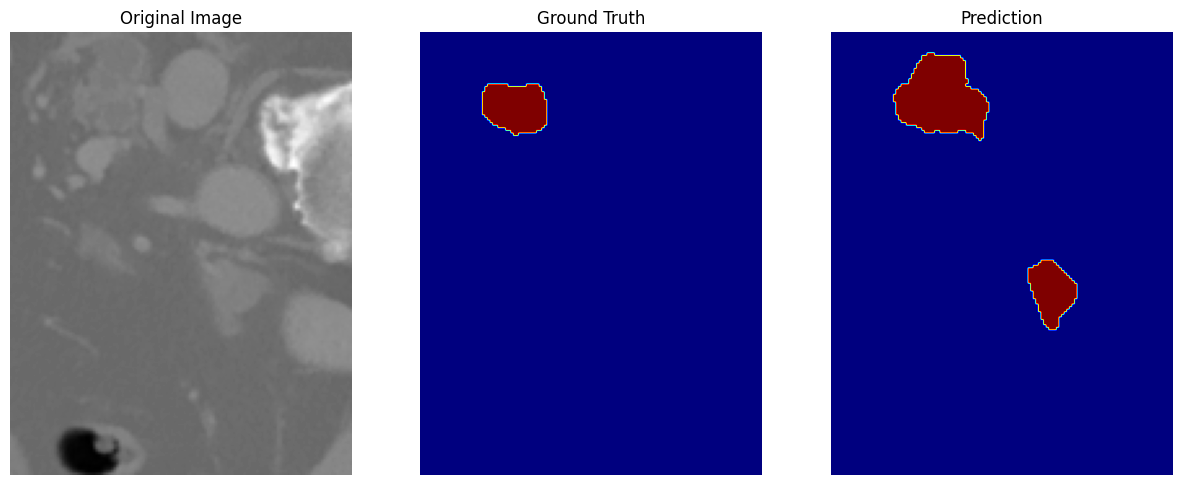

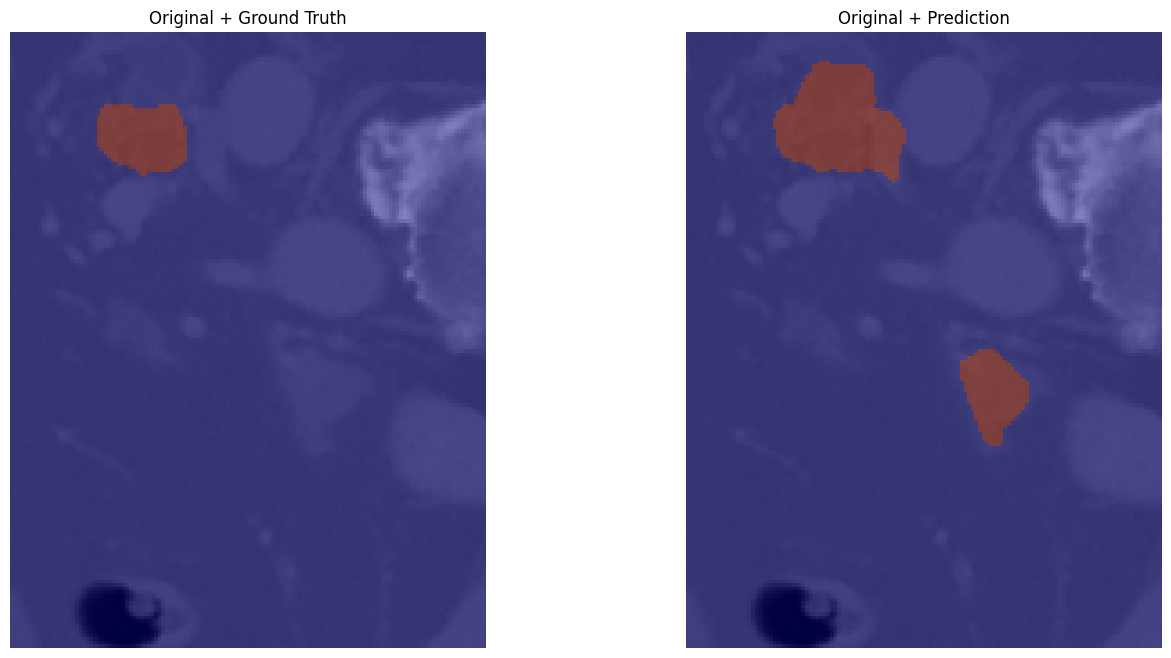

In [16]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

def load_nifti_image(file_path):
    """Load a NIfTI image and return the data as a numpy array."""
    nifti_image = nib.load(file_path)
    return nifti_image.get_fdata()

def show_slices(slices, titles=None, cmaps=None):
    """Function to display a row of image slices."""
    fig, axes = plt.subplots(1, len(slices), figsize=(15, 15))
    for i, slice in enumerate(slices):
        axes[i].imshow(slice, cmap=cmaps[i] if cmaps else 'gray')
        if titles:
            axes[i].set_title(titles[i])
        axes[i].axis('off')
    plt.show()

def show_overlay(image, label, prediction, slice_index, alpha=0.5):
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    
    # Original + Ground Truth
    axes[0].imshow(image[:, :, slice_index], cmap='gray')
    axes[0].imshow(label[:, :, slice_index], cmap='jet', alpha=alpha)
    axes[0].set_title('Original + Ground Truth')
    axes[0].axis('off')

    # Original + Prediction
    axes[1].imshow(image[:, :, slice_index], cmap='gray')
    axes[1].imshow(prediction[:, :, slice_index], cmap='jet', alpha=alpha)
    axes[1].set_title('Original + Prediction')
    axes[1].axis('off')
    
    plt.show()

# Define paths to the original image and prediction files
original_image_path = '/scratch/alif/nnUNet/nnUNet_raw/Dataset006_PancreasUHN/imagesTr/case_0009_0000.nii.gz'  
label_path = '/scratch/alif/nnUNet/nnUNet_raw/Dataset006_PancreasUHN/labelsTr/case_0009.nii.gz'  
prediction_path = '/scratch/alif/nnUNet/nnUNet_results/Dataset006_PancreasUHN/nnUNetTrainer_1epoch__nnUNetPlans__3d_fullres/fold_0/validation/case_0009.nii.gz'

# Load image and prediction
label = load_nifti_image(label_path)
original_image = load_nifti_image(original_image_path)
prediction = load_nifti_image(prediction_path)

# Select a slice to display
slice_index = original_image.shape[2] // 2

# Display the original image, ground truth label, and prediction side by side
show_slices(
    [original_image[:, :, slice_index], label[:, :, slice_index], prediction[:, :, slice_index]],
    titles=['Original Image', 'Ground Truth', 'Prediction'],
    cmaps=['gray', 'jet', 'jet']
)

# Display overlay of original image with ground truth and prediction
show_overlay(original_image, label, prediction, slice_index)


# Hippocampus Dataset

In [83]:
def make_if_dont_exist(folder_path,overwrite=False):
    """
    creates a folder if it does not exists
    input: 
    folder_path : relative path of the folder which needs to be created
    over_write :(default: False) if True overwrite the existing folder 
    """
    if os.path.exists(folder_path):
        
        if not overwrite:
            print(f"{folder_path} exists.")
        else:
            print(f"{folder_path} overwritten")
            shutil.rmtree(folder_path)
            os.makedirs(folder_path)

    else:
      os.makedirs(folder_path)
      print(f"{folder_path} created!")

# Maybe move path of preprocessed data directly on content - this may be signifcantely faster!
print("Current Working Directory {}".format(os.getcwd()))
path_dict = {
    "nnUNet_raw" : os.path.join(os.getcwd(), "nnUNet_raw"), 
    "nnUNet_preprocessed" : os.path.join(os.getcwd(), "nnUNet_preprocessed"), # 1 experiment: 1 epoch took 112s
    "nnUNet_results" : os.path.join(os.getcwd(), "nnUNet_results"),
    "RAW_DATA_PATH" : os.path.join(os.getcwd(), "original_data"), # This is used here only for convenience (not necessary for nnU-Net)!
}

# Write paths to environment variables
for env_var, path in path_dict.items():
  os.environ[env_var] = path 

# Check whether all environment variables are set correct!
for env_var, path in path_dict.items():
  if os.getenv(env_var) != path:
    print("Error:")
    print("Environment Variable {} is not set correctly!".format(env_var))
    print("Should be {}".format(path))
    print("Variable is {}".format(os.getenv(env_var)))
  make_if_dont_exist(path, overwrite=False)

print("If No Error Occured Continue Forward. =)")

Current Working Directory /scratch/alif/nnUNet
/scratch/alif/nnUNet/nnUNet_raw exists.
/scratch/alif/nnUNet/nnUNet_preprocessed exists.
/scratch/alif/nnUNet/nnUNet_results exists.
/scratch/alif/nnUNet/original_data exists.
If No Error Occured Continue Forward. =)


In [90]:
# os.environ['nnUNet_raw_data_base'] = '/scratch/alif/nnUNet/original_data'
os.environ['nnUNet_raw_data_base'] = '/scratch/alif/nnUNet/nnUNet_raw_data_base'
os.environ['nnUNet_preprocessed'] = '/scratch/alif/nnUNet/nnUNet_preprocessed'
os.environ['RESULTS_FOLDER'] = '/scratch/alif/nnUNet/nnUNet_trained_models'

In [102]:
train_dir = '/scratch/alif/nnUNet/nnUNet_raw_data_base/nnUNet_raw_data/Task004_Hippocampus/imagesTr'
test_dir = '/scratch/alif/nnUNet/nnUNet_raw_data_base/nnUNet_raw_data/Task004_Hippocampus/imagesTs'

In [111]:
import os
def remove_suffix(images_dir):
    image_files = sorted(os.listdir(images_dir))
    
    for i, img_file in enumerate(image_files):
        new_image_name = img_file.replace('_0000.', '.')
        os.rename(os.path.join(images_dir, img_file), os.path.join(images_dir, new_image_name))
        
remove_suffix(train_dir)
# remove_suffix(test_dir)

In [128]:
import os
def add_suffix(images_dir):
    image_files = sorted(os.listdir(images_dir))
    
    for i, img_file in enumerate(image_files):
        new_image_name = img_file.replace('.nii.gz', '_0000.nii.gz')
        os.rename(os.path.join(images_dir, img_file), os.path.join(images_dir, new_image_name))
        
# add_suffix(train_dir)
add_suffix(test_dir)

In [118]:
! rm nnUNet_raw_data_base/nnUNet_raw_data/Task004_Hippocampus/imagesTs/._*

rm: cannot remove 'nnUNet_raw_data_base/nnUNet_raw_data/Task004_Hippocampus/imagesTs/._*': No such file or directory


In [119]:
! ls nnUNet_raw_data_base/nnUNet_raw_data/Task004_Hippocampus/imagesTr | wc -l
! ls nnUNet_raw_data_base/nnUNet_raw_data/Task004_Hippocampus/imagesTs | wc -l

260
130


**Examples** <br>
Only train and test (not labels) should have suffixes.
- nnUNet/nnUNet_raw_data_base/nnUNet_raw_data/Task004_Hippocampus/imagesTr/hippocampus_001_0000.nii.gz
- nnUNet/nnUNet_raw_data_base/nnUNet_raw_data/Task004_Hippocampus/labelsTr/hippocampus_001.nii.gz
- nnUNet/nnUNet_raw_data_base/nnUNet_raw_data/Task004_Hippocampus/imagesTs/hippocampus_196_0000.nii.gz

<br>

**JSON** <br>
Should have no suffixes.

```json
{ 
 "name": "Hippocampus", 
 "description": "Left and right hippocampus segmentation",
"reference": " Vanderbilt University Medical Center",
"licence":"CC-BY-SA 4.0",
"relase":"1.0 04/05/2018",
"tensorImageSize": "3D",
"modality": { 
   "0": "MRI"
 }, 
 "labels": { 
   "0": "background", 
   "1": "Anterior", 
   "2": "Posterior"
 }, 
 "numTraining": 260, 
 "numTest": 130,
 "training":[{"image":"./imagesTr/hippocampus_367.nii.gz","label":"./labelsTr/hippocampus_367.nii.gz"},{"image":"./imagesTr/hippocampus_304.nii.gz","label":"./labelsTr/hippocampus_304.nii.gz"},{"image":"./imagesTr/hippocampus_204.nii.gz","label":"./labelsTr/hippocampus_204.nii.gz"},{"image":"./imagesTr/hippocampus_279.nii.gz","label":"./labelsTr/hippocampus_279.nii.gz"},{"image":"./imagesTr/hippocampus_308.nii.gz","label":"./labelsTr/hippocampus_308.nii.gz"},{"image":"./imagesTr/hippocampus_375.nii.gz","label":"./labelsTr/hippocampus_375.nii.gz"},
             ...]
 "test":["./imagesTs/hippocampus_267.nii.gz","./imagesTs/hippocampus_379.nii.gz","./imagesTs/hippocampus_208.nii.gz","./imagesTs/hippocampus_275.nii.gz", ...]
}

```

In [125]:
import os
import json

def create_dataset_json(base_dir, task_name, num_training, num_test):
    
    imagesTr_dir = os.path.join(base_dir, task_name, 'imagesTr')
    labelsTr_dir = os.path.join(base_dir, task_name, 'labelsTr')
    imagesTs_dir = os.path.join(base_dir, task_name, 'imagesTs')

    # Get list of training and test images
    training_images = sorted(os.listdir(imagesTr_dir))
    test_images = sorted(os.listdir(imagesTs_dir))

    # Ensure the number of requested training and test images does not exceed available images
    num_training = min(num_training, len(training_images))
    num_test = min(num_test, len(test_images))

    # Create the dataset dictionary
    dataset = {
        "name": "Hippocampus",
        "description": "Left and right hippocampus segmentation",
        "tensorImageSize": "3D",
        "reference": "",
        "licence": "",
        "release": "0.0",
        "modality": {
            "0": "MRI"
        },
        "labels": {
            "0":"background",
            "1":"Anterior",
            "2":"Posterior"
            # Add other structures as needed
        },
        "numTraining": num_training,
        "numTest": num_test,
        "training": [],
        "test": []
    }

    # Populate the training field
    for i in range(num_training):
        dataset['training'].append({
            # "image": f"./imagesTr/{training_images[i]}",
            "image": f"./imagesTr/{training_images[i].replace('_0000.nii.gz', '.nii.gz')}",
            "label": f"./labelsTr/{training_images[i].replace('_0000.nii.gz', '.nii.gz')}"
        })

    # Populate the test field
    for i in range(num_test):
        dataset['test'].append(f"./imagesTs/{test_images[i]}")
        # dataset['test'].append(f"./imagesTs/{test_images[i].replace('_0000.nii.gz', '.nii.gz')}")

    # Save the dataset.json file
    with open(os.path.join(base_dir, task_name, 'dataset.json'), 'w') as f:
        json.dump(dataset, f, indent=4)

# Define the parameters
base_dir = '/scratch/alif/nnUNet/nnUNet_raw_data_base/nnUNet_raw_data/'
task_name = 'Task004_Hippocampus'  # Replace 002 with the actual task number
num_training = 260  # Set the number of training samples
num_test = 130  # Set the number of test samples

# Create the dataset.json file
create_dataset_json(base_dir, task_name, num_training, num_test)
print('Done')

Done


**WARNING** <br>
The raw data should be located in `nnUNet/nnUNet_raw_data_base/nnUNet_raw_data/Task004_Hippocampus` <br>
It must have 3 digits to specify the task ID.

In [129]:
! nnUNet_plan_and_preprocess -t 04 --verify_dataset_integrity



Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet

Verifying training set
checking case hippocampus_367
checking case hippocampus_304
checking case hippocampus_204
checking case hippocampus_279
checking case hippocampus_308
checking case hippocampus_375
checking case hippocampus_216
checking case hippocampus_316
checking case hippocampus_089
checking case hippocampus_189
checking case hippocampus_243
checking case hippocampus_343
checking case hippocampus_220
checking case hippocampus_097
checking case hippocampus_320
checking case hippocampus_197
checking case hippocampus_351
checking case hippocampus_251
checking case hippocampus_185
checking case hippocampus_332
checking case h

In [131]:
# ! nnUNet_plan_and_preprocess -t 04

In [133]:
! nnUNet_train 3d_fullres nnUNetTrainerV2 Task004_Hippocampus 0 --npz



Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet

###############################################
I am running the following nnUNet: 3d_fullres
My trainer class is:  <class 'nnunet.training.network_training.nnUNetTrainerV2.nnUNetTrainerV2'>
For that I will be using the following configuration:
num_classes:  2
modalities:  {0: 'MRI'}
use_mask_for_norm OrderedDict([(0, False)])
keep_only_largest_region None
min_region_size_per_class None
min_size_per_class None
normalization_schemes OrderedDict([(0, 'nonCT')])
stages...

stage:  0
{'batch_size': 9, 'num_pool_per_axis': [3, 3, 3], 'patch_size': array([40, 56, 40]), 'median_patient_size_in_voxels': array([36, 50, 35]), 'current_spaci

# Pancreas Dataset

In [ ]:
def make_if_dont_exist(folder_path,overwrite=False):
    """
    creates a folder if it does not exists
    input: 
    folder_path : relative path of the folder which needs to be created
    over_write :(default: False) if True overwrite the existing folder 
    """
    if os.path.exists(folder_path):
        
        if not overwrite:
            print(f"{folder_path} exists.")
        else:
            print(f"{folder_path} overwritten")
            shutil.rmtree(folder_path)
            os.makedirs(folder_path)

    else:
      os.makedirs(folder_path)
      print(f"{folder_path} created!")

# Maybe move path of preprocessed data directly on content - this may be signifcantely faster!
print("Current Working Directory {}".format(os.getcwd()))
path_dict = {
    "nnUNet_raw" : os.path.join(os.getcwd(), "nnUNet_raw"), 
    "nnUNet_preprocessed" : os.path.join(os.getcwd(), "nnUNet_preprocessed"), # 1 experiment: 1 epoch took 112s
    "nnUNet_results" : os.path.join(os.getcwd(), "nnUNet_results"),
    "RAW_DATA_PATH" : os.path.join(os.getcwd(), "original_data"), # This is used here only for convenience (not necessary for nnU-Net)!
}

# Write paths to environment variables
for env_var, path in path_dict.items():
  os.environ[env_var] = path 

# Check whether all environment variables are set correct!
for env_var, path in path_dict.items():
  if os.getenv(env_var) != path:
    print("Error:")
    print("Environment Variable {} is not set correctly!".format(env_var))
    print("Should be {}".format(path))
    print("Variable is {}".format(os.getenv(env_var)))
  make_if_dont_exist(path, overwrite=False)

print("If No Error Occured Continue Forward. =)")

In [ ]:
# os.environ['nnUNet_raw_data_base'] = '/scratch/alif/nnUNet/original_data'
os.environ['nnUNet_raw_data_base'] = '/scratch/alif/nnUNet/nnUNet_raw_data_base'
os.environ['nnUNet_preprocessed'] = '/scratch/alif/nnUNet/nnUNet_preprocessed'
os.environ['RESULTS_FOLDER'] = '/scratch/alif/nnUNet/nnUNet_trained_models'

In [138]:
import os
import shutil
import json
import nibabel as nib
import numpy as np

# Define the source directories
source_train = 'original_data/UHN-MedImg3D-ML-quiz/train'
source_val = 'original_data/UHN-MedImg3D-ML-quiz/validation'
source_test = 'original_data/UHN-MedImg3D-ML-quiz/test'

# Define the target directories
target_base = 'original_data'
task_name = 'Task006_PancreasUHN'
target_task_dir = os.path.join(target_base, task_name)
images_tr_dir = os.path.join(target_task_dir, 'imagesTr')
images_ts_dir = os.path.join(target_task_dir, 'imagesTs')
labels_tr_dir = os.path.join(target_task_dir, 'labelsTr')

# Create the target directories if they don't exist
os.makedirs(images_tr_dir, exist_ok=True)
os.makedirs(images_ts_dir, exist_ok=True)
os.makedirs(labels_tr_dir, exist_ok=True)

# Initialize class mapping dictionary
class_mapping = {}

# Function to correct label values
def correct_labels(file_path):
    img = nib.load(file_path)
    data = img.get_fdata()

    print(f"Original unique labels in {file_path}: {np.unique(data)}")

    # Round to nearest valid value
    data_corrected = np.round(data)

    # Explicitly set near values to the exact intended labels
    data_corrected[np.isclose(data_corrected, 0.0)] = 0.0
    data_corrected[np.isclose(data_corrected, 1.0)] = 1.0
    data_corrected[np.isclose(data_corrected, 2.0)] = 2.0

    print(f"Corrected unique labels in {file_path}: {np.unique(data_corrected)}")
    print(f"----------------------------------------------------------------------\n\n")

    # Save the corrected label file to a temporary path
    temp_file_path = file_path.replace('.nii.gz', '_corrected.nii.gz')
    # corrected_img = nib.Nifti1Image(data_corrected, img.affine, img.header)
    corrected_img = nib.Nifti1Image(data_corrected, img.affine)
    
    nib.save(corrected_img, temp_file_path)
    
    return temp_file_path, np.unique(data_corrected), np.unique(data)

# Function to move files and record class labels
def move_files(source, image_dest, label_dest, class_mapping, case_id=0):
    
    if not label_dest:
        case_id = case_id
        total = len(os.listdir(source))
        for file in os.listdir(source):
            if file.endswith('0000.nii.gz'):
                src_image_file = os.path.join(source, file)

                case_str_image = f"case_{case_id:03d}_0000.nii.gz"
                dest_image_file = os.path.join(image_dest, case_str_image)
                shutil.copy(src_image_file, dest_image_file)
                
                print(f"""({case_id}/{total}) Source Image: {src_image_file} 
                      Dest Image: {dest_image_file}
                      Labels: No Class, Not Annotated
                """)
                case_id += 1
                
        return case_id
            
    else:
        case_id = case_id
        for subtype in os.listdir(source):
            subtype_path = os.path.join(source, subtype)
            if os.path.isdir(subtype_path):
                class_id = int(os.path.basename(subtype_path)[-1])
                total = len(os.listdir(subtype_path))
                for file in os.listdir(subtype_path):
                    if file.endswith('0000.nii.gz'):
                        src_image_file = os.path.join(subtype_path, file)

                        case_str_image = f"case_{case_id:03d}_0000.nii.gz"
                        dest_image_file = os.path.join(image_dest, case_str_image)
                        shutil.copy(src_image_file, dest_image_file)

                        src_label_file = src_image_file.replace('_0000.nii.gz', '.nii.gz')
                        
                        # Correct the label file before copying
                        corrected_label_file, unique_labels, orig_labels = correct_labels(src_label_file)
                        # print(corrected_label_file)
                        # print(unique_labels)
                        # print(orig_labels)

                        case_str_label = f"case_{case_id:03d}.nii.gz"
                        dest_label_file = os.path.join(label_dest, case_str_label)
                        
                        shutil.copy(corrected_label_file, dest_label_file)
                        
                        class_mapping[case_str_image] = class_id
                        print(f"""
                        
----------------------------------------------------------------------
({case_id}/{total}) 

Source Image: {src_image_file}
Source Label: {src_label_file}
Corrected Label: {corrected_label_file}
Dest Image: {dest_image_file}
Dest Label: {dest_label_file}
Labels: Class {class_id}, Annotated, Unique labels after correction: {unique_labels}
                        
                        """)
                        case_id += 1
                        # Remove the temporary corrected label file
                        os.remove(corrected_label_file)
                        
        return case_id

# Move training files and record class labels
case_id = move_files(source_train, images_tr_dir, labels_tr_dir, class_mapping, 1)
print("\n\n##################\n\n")
case_id = move_files(source_val, images_tr_dir, labels_tr_dir, class_mapping, case_id)
print("\n\n##################\n\n")
case_id = move_files(source_test, images_ts_dir, None, class_mapping, case_id)

# Save the class mapping to a JSON file
with open(os.path.join(target_task_dir, 'class_mapping.json'), 'w') as f:
    json.dump(class_mapping, f)

print("Data restructuring complete and class mapping saved.")


Original unique labels in original_data/UHN-MedImg3D-ML-quiz/train/subtype2/quiz_2_416.nii.gz: [0. 1. 2.]
Corrected unique labels in original_data/UHN-MedImg3D-ML-quiz/train/subtype2/quiz_2_416.nii.gz: [0. 1. 2.]
----------------------------------------------------------------------



                        
----------------------------------------------------------------------
(1/169) 

Source Image: original_data/UHN-MedImg3D-ML-quiz/train/subtype2/quiz_2_416_0000.nii.gz
Source Label: original_data/UHN-MedImg3D-ML-quiz/train/subtype2/quiz_2_416.nii.gz
Corrected Label: original_data/UHN-MedImg3D-ML-quiz/train/subtype2/quiz_2_416_corrected.nii.gz
Dest Image: original_data/Task006_PancreasUHN/imagesTr/case_001_0000.nii.gz
Dest Label: original_data/Task006_PancreasUHN/labelsTr/case_001.nii.gz
Labels: Class 2, Annotated, Unique labels after correction: [0. 1. 2.]
                        
                        
Original unique labels in original_data/UHN-MedImg3D-ML-quiz/train/subtype2

In [148]:
# import os


# # Directory containing the files
# directory = 'nnUNet_raw_data_base/nnUNet_raw_data/Task006_PancreasUHN/imagesTs'
# start_number = 289
# files = sorted(os.listdir(directory))


# for i, filename in enumerate(files):

#     new_filename = f"case_{start_number + i:03d}_0000.nii.gz"
    
#     old_file = os.path.join(directory, filename)
#     new_file = os.path.join(directory, new_filename)
    
#     os.rename(old_file, new_file)

#     print(f'Renamed: {filename} -> {new_filename}')

In [139]:
import os
import numpy as np
import nibabel as nib

def load_nifti_image(file_path):
    """Load a NIfTI image and return the data as a numpy array."""
    nifti_image = nib.load(file_path)
    return nifti_image.get_fdata()

def collect_unique_labels(labels_dir):
    """Collect and print all unique labels in the dataset."""
    unique_labels = set()
    
    label_files = sorted(os.listdir(labels_dir))
    
    for lbl_file in label_files:
        lbl_path = os.path.join(labels_dir, lbl_file)
        labels = load_nifti_image(lbl_path)
        unique_labels.update(np.unique(labels))
    
    return unique_labels

In [140]:
# Define the path to the labels directory
pancreas_labels_dir = 'original_data/Task006_PancreasUHN/labelsTr'

# Collect unique labels
pancreas_unique_labels = collect_unique_labels(pancreas_labels_dir)

# Print the unique labels
print(f"Unique labels in the dataset: {sorted(pancreas_unique_labels)}")

Unique labels in the dataset: [0.0, 1.0, 2.0]


In [141]:
! mv original_data/Task006_PancreasUHN/ nnUNet_raw_data_base/nnUNet_raw_data/

In [142]:
train_dir = '/scratch/alif/nnUNet/nnUNet_raw_data_base/nnUNet_raw_data/Task006_PancreasUHN/imagesTs'
test_dir = '/scratch/alif/nnUNet/nnUNet_raw_data_base/nnUNet_raw_data/Task006_PancreasUHN/imagesTs'

In [143]:
# remove_suffix(test_dir)

In [149]:
import os
import json

def create_dataset_json(base_dir, task_name, num_training, num_test):
    
    imagesTr_dir = os.path.join(base_dir, task_name, 'imagesTr')
    labelsTr_dir = os.path.join(base_dir, task_name, 'labelsTr')
    imagesTs_dir = os.path.join(base_dir, task_name, 'imagesTs')

    # Get list of training and test images
    training_images = sorted(os.listdir(imagesTr_dir))
    test_images = sorted(os.listdir(imagesTs_dir))

    # Ensure the number of requested training and test images does not exceed available images
    num_training = min(num_training, len(training_images))
    num_test = min(num_test, len(test_images))

    # Create the dataset dictionary
    dataset = {
        "name": "Pancreas_UHN",
        "description": "Segmentation of pancreatic structures using UHN dataset",
        "tensorImageSize": "3D",
        "reference": "",
        "licence": "",
        "release": "0.0",
        "modality": {
            "0": "CT"
        },
        "labels": {
            "0": "background",
            "1": "pancreas",
            "2": "lesion"
            # Add other structures as needed
        },
        "numTraining": num_training,
        "numTest": num_test,
        "training": [],
        "test": []
    }

    # Populate the training field
    # In the dataset file, no files should have _0000 suffix
    for i in range(num_training):
        dataset['training'].append({
            # "image": f"./imagesTr/{training_images[i]}",
            "image": f"./imagesTr/{training_images[i].replace('_0000.nii.gz', '.nii.gz')}",
            "label": f"./labelsTr/{training_images[i].replace('_0000.nii.gz', '.nii.gz')}"
        })

    # Populate the test field
    for i in range(num_test):
        # dataset['test'].append(f"./imagesTs/{test_images[i]}")
        dataset['test'].append(f"./imagesTs/{test_images[i].replace('_0000.nii.gz', '.nii.gz')}")

    # Save the dataset.json file
    with open(os.path.join(base_dir, task_name, 'dataset.json'), 'w') as f:
        json.dump(dataset, f, indent=4)

# Define the parameters
base_dir = '/scratch/alif/nnUNet/nnUNet_raw_data_base/nnUNet_raw_data/'
task_name = 'Task006_PancreasUHN'  # Replace 002 with the actual task number
num_training = 288  # Set the number of training samples
num_test = 72  # Set the number of test samples

# Create the dataset.json file
create_dataset_json(base_dir, task_name, num_training, num_test)
print('Done')

Done


In [150]:
! nnUNet_plan_and_preprocess -t 06 --verify_dataset_integrity



Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet

Verifying training set
checking case case_001
checking case case_002
checking case case_003
checking case case_004
checking case case_005
checking case case_006
checking case case_007
checking case case_008
checking case case_009
checking case case_010
checking case case_011
checking case case_012
checking case case_013
checking case case_014
checking case case_015
the spacing does not match between the images
(0.814453125, 0.814453125, 0.699999988079071)
(0.814453125, 0.814453125, 0.70001220703125)
The geometry of the image /scratch/alif/nnUNet/nnUNet_raw_data_base/nnUNet_raw_data/Task006_PancreasUHN/imagesTr/case_015 does not ma

In [154]:
! nnUNet_plan_and_preprocess -t 06 -tf 14 -tl 14



Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet

case_001
case_013
case_007
case_019
case_025
case_031
case_037
case_043
case_049
case_055
case_061
case_067
case_073
case_079
before crop: (1, 68, 143, 176) after crop: (1, 68, 143, 176) spacing: [1.5        0.62890625 0.62890625] 

before crop: (1, 73, 97, 161) after crop: (1, 73, 97, 161) spacing: [1.5        0.71679688 0.71679688] 

before crop: (1, 117, 149, 204) after crop: (1, 117, 149, 204) spacing: [1.        0.7265625 0.7265625] 

before crop: (1, 45, 157, 155) after crop: (1, 45, 157, 155) spacing: [3.         0.69921875 0.69921875] 

case_008
before crop: (1, 50, 124, 201) after crop: (1, 50, 124, 201) spacing: [3.     

In [156]:
! nnUNet_train 3d_fullres nnUNetTrainerV2_Custom Task006_PancreasUHN 0



Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet

###############################################
I am running the following nnUNet: 3d_fullres
My trainer class is:  <class 'nnunet.training.network_training.custom_trainer.nnUNetTrainerV2_Custom'>
For that I will be using the following configuration:
num_classes:  2
modalities:  {0: 'CT'}
use_mask_for_norm OrderedDict([(0, False)])
keep_only_largest_region None
min_region_size_per_class None
min_size_per_class None
normalization_schemes OrderedDict([(0, 'CT')])
stages...

stage:  0
{'batch_size': 2, 'num_pool_per_axis': [4, 5, 5], 'patch_size': array([ 64, 128, 192]), 'median_patient_size_in_voxels': array([ 59, 117, 181]), 'curre

# Create Splits

In [ ]:
import os
import shutil
import json
import nibabel as nib
import numpy as np

source_train = 'original_data/UHN-MedImg3D-ML-quiz/train'
source_val = 'original_data/UHN-MedImg3D-ML-quiz/validation'
source_test = 'original_data/UHN-MedImg3D-ML-quiz/test'


# Initialize class mapping dictionary
class_mapping = {}

# Function to move files and record class labels
def create_splits(source, class_mapping, case_id=0):
    
    if not label_dest:
        case_id = case_id
        total = len(os.listdir(source))
        for file in os.listdir(source):
            if file.endswith('0000.nii.gz'):
                src_image_file = os.path.join(source, file)

                case_str_image = f"case_{case_id:03d}_0000.nii.gz"
                dest_image_file = os.path.join(image_dest, case_str_image)
                
                case_id += 1         
        return case_id
            
    else:
        case_id = case_id
        for subtype in os.listdir(source):
            subtype_path = os.path.join(source, subtype)
            if os.path.isdir(subtype_path):
                class_id = int(os.path.basename(subtype_path)[-1])
                total = len(os.listdir(subtype_path))
                for file in os.listdir(subtype_path):
                    if file.endswith('0000.nii.gz'):
                        
                        src_image_file = os.path.join(subtype_path, file)
                        case_str_image = f"case_{case_id:03d}_0000.nii.gz"
                        dest_image_file = os.path.join(image_dest, case_str_image)
                        
                        src_label_file = src_image_file.replace('_0000.nii.gz', '.nii.gz')
                        case_str_label = f"case_{case_id:03d}.nii.gz"
                        dest_label_file = os.path.join(label_dest, case_str_label)
                        
                        class_mapping[case_str_image] = class_id

                        case_id += 1
                        # Remove the temporary corrected label file
                        os.remove(corrected_label_file)
                        
        return case_id

case_id = create_splits(source_train, class_mapping, 1)
print("\n\n##################\n\n")
case_id = create_splits(source_val, class_mapping, case_id)


In [165]:
import os
import shutil
import json
import nibabel as nib
import numpy as np

# Define the source directories
source_train = 'original_data/UHN-MedImg3D-ML-quiz/train'
source_val = 'original_data/UHN-MedImg3D-ML-quiz/validation'
source_test = 'original_data/UHN-MedImg3D-ML-quiz/test'

# Define the target directories
target_base = 'original_data'
task_name = 'Task006_PancreasUHN'
target_task_dir = os.path.join(target_base, task_name)
images_tr_dir = os.path.join(target_task_dir, 'imagesTr')
images_ts_dir = os.path.join(target_task_dir, 'imagesTs')
labels_tr_dir = os.path.join(target_task_dir, 'labelsTr')

# Create the target directories if they don't exist
os.makedirs(images_tr_dir, exist_ok=True)
os.makedirs(images_ts_dir, exist_ok=True)
os.makedirs(labels_tr_dir, exist_ok=True)

# Initialize class mapping and file mapping dictionaries
class_mapping = {}
file_mapping = {}

# Function to move files and record class labels
def map_files(source, image_dest, label_dest, class_mapping, case_id=0):
    
    if not label_dest:
        total = len(os.listdir(source))
        for file in os.listdir(source):
            if file.endswith('0000.nii.gz'):
                src_image_file = os.path.join(source, file)
                case_str_image = f"case_{case_id:03d}"
                dest_image_file = os.path.join(image_dest, case_str_image)

                # Store the original and renamed file paths in the mapping
                file_mapping[src_image_file] = dest_image_file
                
                case_id += 1
                
        return case_id
            
    else:
        for subtype in os.listdir(source):
            subtype_path = os.path.join(source, subtype)
            if os.path.isdir(subtype_path):
                class_id = int(os.path.basename(subtype_path)[-1])
                total = len(os.listdir(subtype_path))
                for file in os.listdir(subtype_path):
                    if file.endswith('0000.nii.gz'):
                        src_image_file = os.path.join(subtype_path, file)
                        case_str_image = f"case_{case_id:03d}"
                        dest_image_file = os.path.join(image_dest, case_str_image)

                        # Store the original and renamed file paths in the mapping
                        file_mapping[src_image_file] = dest_image_file

                        src_label_file = src_image_file.replace('_0000.nii.gz', '.nii.gz')

                        case_str_label = f"case_{case_id:03d}.nii.gz"
                        dest_label_file = os.path.join(label_dest, case_str_label)
                        
                        class_mapping[case_str_image] = class_id

                        case_id += 1
                        
        return case_id

# Move training files and record class labels
case_id = map_files(source_train, images_tr_dir, labels_tr_dir, class_mapping, 1)
print("\n\n##################\n\n")
case_id = map_files(source_val, images_tr_dir, labels_tr_dir, class_mapping, case_id)
print("\n\n##################\n\n")
case_id = map_files(source_test, images_ts_dir, None, class_mapping, case_id)

# Save the class mapping to a JSON file



##################




##################




In [174]:
import pandas as pd

# Set maximum number of rows to display
pd.set_option('display.max_rows', None)

# Set maximum number of columns to display
pd.set_option('display.max_columns', None)

# Set maximum display width
pd.set_option('display.width', 1000)

# Set maximum number of columns to display
pd.set_option('display.max_columns', None)

# Set maximum column width
pd.set_option('display.max_colwidth', None)

df = pd.DataFrame.from_dict(file_mapping, orient='index', columns=['Renamed Path'])

# Rename the index to 'Original Path'
df.index.name = 'Original Path'

# Reset the index to make 'Original Path' a column
df.reset_index(inplace=True)

In [178]:
df_train = df[df['Original Path'].str.contains('train')]
df_test = df[df['Original Path'].str.contains('test')]
df_val = df[df['Original Path'].str.contains('validation')]

In [179]:
df_train

,Original Path,Renamed Path
0,original_data/UHN-MedImg3D-ML-quiz/train/subtype2/quiz_2_416_0000.nii.gz,original_data/Task006_PancreasUHN/imagesTr/case_001
1,original_data/UHN-MedImg3D-ML-quiz/train/subtype2/quiz_2_040_0000.nii.gz,original_data/Task006_PancreasUHN/imagesTr/case_002
2,original_data/UHN-MedImg3D-ML-quiz/train/subtype2/quiz_2_493_0000.nii.gz,original_data/Task006_PancreasUHN/imagesTr/case_003
3,original_data/UHN-MedImg3D-ML-quiz/train/subtype2/quiz_2_321_0000.nii.gz,original_data/Task006_PancreasUHN/imagesTr/case_004
4,original_data/UHN-MedImg3D-ML-quiz/train/subtype2/quiz_2_002_0000.nii.gz,original_data/Task006_PancreasUHN/imagesTr/case_005
5,original_data/UHN-MedImg3D-ML-quiz/train/subtype2/quiz_2_501_0000.nii.gz,original_data/Task006_PancreasUHN/imagesTr/case_006
6,original_data/UHN-MedImg3D-ML-quiz/train/subtype2/quiz_2_387_0000.nii.gz,original_data/Task006_PancreasUHN/imagesTr/case_007
7,original_data/UHN-MedImg3D-ML-quiz/train/subtype2/quiz_2_004_0000.nii.gz,original_data/Task006_PancreasUHN/imagesTr/case_008
8,original_data/UHN-MedImg3D-ML-quiz/train/subtype2/quiz_2_051_0000.nii.gz,original_data/Task006_PancreasUHN/imagesTr/case_009
9,original_data/UHN-MedImg3D-ML-quiz/train/subtype2/quiz_2_058_0000.nii.gz,original_data/Task006_PancreasUHN/imagesTr/case_010


In [180]:
df_val

,Original Path,Renamed Path
252,original_data/UHN-MedImg3D-ML-quiz/validation/subtype2/quiz_2_191_0000.nii.gz,original_data/Task006_PancreasUHN/imagesTr/case_253
253,original_data/UHN-MedImg3D-ML-quiz/validation/subtype2/quiz_2_241_0000.nii.gz,original_data/Task006_PancreasUHN/imagesTr/case_254
254,original_data/UHN-MedImg3D-ML-quiz/validation/subtype2/quiz_2_084_0000.nii.gz,original_data/Task006_PancreasUHN/imagesTr/case_255
255,original_data/UHN-MedImg3D-ML-quiz/validation/subtype2/quiz_2_377_0000.nii.gz,original_data/Task006_PancreasUHN/imagesTr/case_256
256,original_data/UHN-MedImg3D-ML-quiz/validation/subtype2/quiz_2_098_0000.nii.gz,original_data/Task006_PancreasUHN/imagesTr/case_257
257,original_data/UHN-MedImg3D-ML-quiz/validation/subtype2/quiz_2_089_0000.nii.gz,original_data/Task006_PancreasUHN/imagesTr/case_258
258,original_data/UHN-MedImg3D-ML-quiz/validation/subtype2/quiz_2_085_0000.nii.gz,original_data/Task006_PancreasUHN/imagesTr/case_259
259,original_data/UHN-MedImg3D-ML-quiz/validation/subtype2/quiz_2_080_0000.nii.gz,original_data/Task006_PancreasUHN/imagesTr/case_260
260,original_data/UHN-MedImg3D-ML-quiz/validation/subtype2/quiz_2_074_0000.nii.gz,original_data/Task006_PancreasUHN/imagesTr/case_261
261,original_data/UHN-MedImg3D-ML-quiz/validation/subtype2/quiz_2_088_0000.nii.gz,original_data/Task006_PancreasUHN/imagesTr/case_262


In [181]:
df_test

,Original Path,Renamed Path
288,original_data/UHN-MedImg3D-ML-quiz/test/quiz_037_0000.nii.gz,original_data/Task006_PancreasUHN/imagesTs/case_289
289,original_data/UHN-MedImg3D-ML-quiz/test/quiz_512_0000.nii.gz,original_data/Task006_PancreasUHN/imagesTs/case_290
290,original_data/UHN-MedImg3D-ML-quiz/test/quiz_045_0000.nii.gz,original_data/Task006_PancreasUHN/imagesTs/case_291
291,original_data/UHN-MedImg3D-ML-quiz/test/quiz_391_0000.nii.gz,original_data/Task006_PancreasUHN/imagesTs/case_292
292,original_data/UHN-MedImg3D-ML-quiz/test/quiz_056_0000.nii.gz,original_data/Task006_PancreasUHN/imagesTs/case_293
293,original_data/UHN-MedImg3D-ML-quiz/test/quiz_361_0000.nii.gz,original_data/Task006_PancreasUHN/imagesTs/case_294
294,original_data/UHN-MedImg3D-ML-quiz/test/quiz_499_0000.nii.gz,original_data/Task006_PancreasUHN/imagesTs/case_295
295,original_data/UHN-MedImg3D-ML-quiz/test/quiz_282_0000.nii.gz,original_data/Task006_PancreasUHN/imagesTs/case_296
296,original_data/UHN-MedImg3D-ML-quiz/test/quiz_373_0000.nii.gz,original_data/Task006_PancreasUHN/imagesTs/case_297
297,original_data/UHN-MedImg3D-ML-quiz/test/quiz_141_0000.nii.gz,original_data/Task006_PancreasUHN/imagesTs/case_298


In [162]:
import os
import pickle
import numpy as np
from collections import OrderedDict

# Paths to the data
source_train = 'original_data/UHN-MedImg3D-ML-quiz/train'
source_val = 'original_data/UHN-MedImg3D-ML-quiz/validation'


# Function to create splits
def create_splits(source, case_id=0):
    cases = []
    for subtype in os.listdir(source):
        subtype_path = os.path.join(source, subtype)
        if os.path.isdir(subtype_path):
            for file in os.listdir(subtype_path):
                if file.endswith('0000.nii.gz'):
                    case_str = f"case_{case_id:03d}"
                    cases.append(case_str)
                    case_id += 1
    return cases, case_id

# Create training and validation splits
train_cases, case_id = create_splits(source_train, case_id=1)
val_cases, _ = create_splits(source_val, case_id)

# Create the splits dictionary
splits = [
    OrderedDict([
        ('train', np.array(train_cases, dtype='<U8')),
        ('val', np.array(val_cases, dtype='<U8'))
    ])
]

In [163]:
splits

[OrderedDict([('train',
               array(['case_001', 'case_002', 'case_003', 'case_004', 'case_005',
                      'case_006', 'case_007', 'case_008', 'case_009', 'case_010',
                      'case_011', 'case_012', 'case_013', 'case_014', 'case_015',
                      'case_016', 'case_017', 'case_018', 'case_019', 'case_020',
                      'case_021', 'case_022', 'case_023', 'case_024', 'case_025',
                      'case_026', 'case_027', 'case_028', 'case_029', 'case_030',
                      'case_031', 'case_032', 'case_033', 'case_034', 'case_035',
                      'case_036', 'case_037', 'case_038', 'case_039', 'case_040',
                      'case_041', 'case_042', 'case_043', 'case_044', 'case_045',
                      'case_046', 'case_047', 'case_048', 'case_049', 'case_050',
                      'case_051', 'case_052', 'case_053', 'case_054', 'case_055',
                      'case_056', 'case_057', 'case_058', 'case_059', 'cas

In [182]:
split_file_path = 'nnUNet_preprocessed/Task006_PancreasUHN/splits_custom_uhn.pkl'

# Save the splits to a pickle file
with open(split_file_path, 'wb') as f:
    pickle.dump(splits, f)

print("Splits saved to", split_file_path)


Splits saved to nnUNet_preprocessed/Task006_PancreasUHN/splits_custom_uhn.pkl
